# Using Machine Learning to Guide Next Experiments; Active learning

In this tutorial we will take on a materials design challenge. Given

1. a (training) dataset of materials and their properties,
2. a candidate pool dataset with just the materials (no knowledge on their properties),

our goal will be to find the most promising candidate from the candidate pool with the best prorperties. Further, the process will be iterative. As the ML proposes a promising candidate, the experimnet will be performed on that candidate (virtually), and the associated properry will be revealed and added to the training dataset. We will achieve the following:
1. Train GPR model on train dataset
2. Use ML model prediction and uncertainties to find the best promising candidate
3. Obtain the property value of the proposed candidate and add it to the train dataset
4. Repeat steps 1-3 for 50 steps with different acquisition functions (Active learning loop)
5. Evaluate which acquisition function performs the best

Note: This tutorial is based on the data from the following publication

Quantifying machine learning model performance in materials discovery, Borg et al., arXiv.2210.13587 [cond-mat.mtrl-sci] (2022). DOI: 10.48550/arXiv.2210.13587.

In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [ ]:
from scipy.stats import norm

In [ ]:
import seaborn as sns

### 0. Read train and candidate pool data

In [ ]:
!gdown 12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h

Downloading...
From: https://drive.google.com/uc?id=12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h
To: /content/alloy-confp-train-data_v2.csv
100% 7.33k/7.33k [00:00<00:00, 12.5MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
full_train_data = pd.read_csv('/content/drive/MyDrive/ML-Project-Group10/alloy-full-train-DATASET new 1.csv')
train_data_ori = full_train_data.copy()

In [ ]:
#nfrac = 1
#train_data = train_data.sample(frac=nfrac)

In [ ]:
full_train_data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,...,sqrt_C.cu,exp_C.fe,exp_neg_C.fe,cubed_C.fe,squared_C.fe,sqrt_C.fe,exp_C.ni.1,exp_neg_C.ni,cubed_C.ni,squared_C.ni
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,-2.442590,1.931601,...,0.000000,1.284025,0.778801,0.015625,0.062500,0.500000,1.284025,0.778801,0.015625,0.062500
1,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.575486,-1.738410,...,0.471405,1.248849,0.800737,0.010974,0.049383,0.471405,1.248849,0.800737,0.010974,0.049383
2,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,1.093749,-2.322860,...,0.267261,1.074041,0.931063,0.000364,0.005102,0.267261,1.153565,0.866878,0.002915,0.020408
3,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,-0.319490,0.221026,...,0.426401,1.199396,0.833753,0.006011,0.033058,0.426401,1.199396,0.833753,0.006011,0.033058
4,141,655,0.149925,0.283358,0.283358,0.000000,0.283358,0.000000,0.241201,1.115530,...,0.000000,1.327581,0.753250,0.022751,0.080292,0.532314,1.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,82,476,0.225000,0.225000,0.100000,0.000000,0.225000,0.225000,0.698325,-0.400130,...,0.000000,1.252323,0.798516,0.011391,0.050625,0.474342,1.252323,0.798516,0.011391,0.050625
96,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.014367,1.557345,...,0.000000,1.554535,0.643279,0.085869,0.194637,0.664211,1.158422,0.863243,0.003180,0.021626
97,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.320476,-0.019970,...,0.288675,1.181360,0.846482,0.004630,0.027778,0.408248,1.181360,0.846482,0.004630,0.027778
98,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.353340,1.187070,...,0.000000,1.181360,0.846482,0.004630,0.027778,0.408248,1.181360,0.846482,0.004630,0.027778


In [ ]:
Xcols = full_train_data.columns[(full_train_data.columns.str.contains("C.")) | (full_train_data.columns.str.contains("Dk_"))]
Xcols

Index(['C.al', 'C.co', 'C.cr', 'C.cu', 'C.fe', 'C.ni', 'Dk_fr', 'Dk_G',
       'Dk_fG', 'Dk_fx', 'Dk_e.a', 'Dk_vec', 'Dk_Ec', 'Dk_w', 'Dk_fS',
       'Dk_D.r', 'Dk_D.G', 'Dk_D.x', 'Dk_fH', 'Dk_fpi', 'Dk_fdash', 'Dk_fA',
       'Dk_A', 'Dk_F', 'Dk_fineq', 'Dk_fsqrt', 'sqrt_C.co', 'exp_C.ni',
       'sqrt_Dk_D.x', 'sqrt_C.ni', 'sqrt_Dk_fineq', 'exp_Dk_fH',
       'exp_neg_Dk_fH', 'exp_neg_Dk_fsqrt', 'cubed_Dk_fsqrt',
       'squared_Dk_fsqrt', 'sqrt_Dk_fsqrt', 'sqrt_C.cr', 'exp_C.cu',
       'exp_neg_C.cu', 'cubed_C.cu', 'squared_C.cu', 'sqrt_C.cu', 'exp_C.fe',
       'exp_neg_C.fe', 'cubed_C.fe', 'squared_C.fe', 'sqrt_C.fe', 'exp_C.ni.1',
       'exp_neg_C.ni', 'cubed_C.ni', 'squared_C.ni'],
      dtype='object')

In [ ]:
y = full_train_data['HV']
y

0     139
1     545
2     701
3     207
4     655
     ... 
95    476
96    450
97    451
98    617
99    171
Name: HV, Length: 100, dtype: int64

In [ ]:
new_data = full_train_data.copy()

In [ ]:
def make_new_feature(full_train_data, cols, powers, new_col_name):
    full_train_data[new_col_name] = 1
    for power, col  in zip(powers, cols):
        full_train_data[new_col_name] = np.cos(full_train_data[new_col_name]) * np.sin((full_train_data[Xcols[col]]) ** power)

    return full_train_data

def make_new_feature1(full_train_data, cols, powers, new_col_name):
    full_train_data[new_col_name] = 1
    for power, col  in zip(powers, cols):
        full_train_data[new_col_name] = full_train_data[new_col_name] * np.sin((full_train_data[Xcols[col]]) ** power)

    return full_train_data

In [ ]:
cols = [0,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.1')

cols = [1,3]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.2')

cols = [0,0]
powers = [1,2]
new_data = make_new_feature(new_data, cols, powers, 'C.3')

cols = [0,0,0]
powers = [1,1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.4')

cols = [4,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.5')

cols = [3,1]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.6')

cols = [9,8]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.7')

cols = [5,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.8')

cols = [0,16]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.9')

cols = [0,16]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.10')

cols = [4,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.11')

cols = [0,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'D.1')

cols = [0,11]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'D.2')

cols = [9,14]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'D.3')

cols = [11,21]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'D.4')

In [ ]:
new_data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,...,C.6,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,-2.442590,1.931601,...,0.247404,-0.735600,0.000000,-0.659447,-0.659447,0.000000,0.000000,0.686125,-0.821190,-0.835139
1,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.575486,-1.738410,...,0.110097,-0.082933,0.218837,0.114522,0.114522,0.218837,0.218837,0.538307,0.209229,0.270661
2,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,1.093749,-2.322860,...,0.212491,0.855442,0.414343,0.872863,0.872863,0.415263,0.405140,-0.972153,-0.098731,0.662067
3,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,-0.319490,0.221026,...,0.179956,-0.326621,0.090351,-0.255700,-0.255700,0.090351,0.090675,0.706767,0.974089,-0.506048
4,141,655,0.149925,0.283358,0.283358,0.000000,0.283358,0.000000,0.241201,1.115530,...,0.279582,-0.281224,0.149364,-0.099796,-0.099796,0.147663,0.148878,-0.802448,-0.977057,0.357031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,82,476,0.225000,0.225000,0.100000,0.000000,0.225000,0.225000,0.698325,-0.400130,...,0.223106,0.029332,0.221487,0.052621,0.052621,0.221487,0.221487,-0.414504,0.147070,0.732714
96,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.014367,1.557345,...,0.000000,-0.625169,0.117008,-0.560307,-0.560307,0.114266,0.117140,-0.670822,-0.786671,0.068169
97,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.320476,-0.019970,...,0.247154,-0.000688,0.165230,0.119873,0.119873,0.165230,0.165230,-0.013067,0.987899,0.304683
98,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.353340,1.187070,...,0.165896,-0.049234,0.165230,0.199842,0.199842,0.165230,0.165230,-0.775386,0.060009,0.510668


In [ ]:
Xcols = new_data.columns[new_data.columns.str.contains("C.") | new_data.columns.str.contains("Dk_.") | new_data.columns.str.contains("C.")| new_data.columns.str.contains("D.")]
X = new_data[Xcols]
X   # 67 columns ###########################################################

,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,Dk_fG,Dk_fx,...,C.6,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4
0,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,-2.442590,1.931601,-2.141950,-1.215900,...,0.247404,-0.735600,0.000000,-0.659447,-0.659447,0.000000,0.000000,0.686125,-0.821190,-0.835139
1,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.575486,-1.738410,-0.083060,-0.051180,...,0.110097,-0.082933,0.218837,0.114522,0.114522,0.218837,0.218837,0.538307,0.209229,0.270661
2,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,1.093749,-2.322860,1.670192,1.446628,...,0.212491,0.855442,0.414343,0.872863,0.872863,0.415263,0.405140,-0.972153,-0.098731,0.662067
3,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,-0.319490,0.221026,-0.341910,-0.435350,...,0.179956,-0.326621,0.090351,-0.255700,-0.255700,0.090351,0.090675,0.706767,0.974089,-0.506048
4,0.149925,0.283358,0.283358,0.000000,0.283358,0.000000,0.241201,1.115530,-0.289360,-0.320160,...,0.279582,-0.281224,0.149364,-0.099796,-0.099796,0.147663,0.148878,-0.802448,-0.977057,0.357031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.225000,0.225000,0.100000,0.000000,0.225000,0.225000,0.698325,-0.400130,0.029721,0.302827,...,0.223106,0.029332,0.221487,0.052621,0.052621,0.221487,0.221487,-0.414504,0.147070,0.732714
96,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.014367,1.557345,-0.705380,-0.519140,...,0.000000,-0.625169,0.117008,-0.560307,-0.560307,0.114266,0.117140,-0.670822,-0.786671,0.068169
97,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.320476,-0.019970,-0.000690,0.152051,...,0.247154,-0.000688,0.165230,0.119873,0.119873,0.165230,0.165230,-0.013067,0.987899,0.304683
98,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.353340,1.187070,-0.050140,0.355758,...,0.165896,-0.049234,0.165230,0.199842,0.199842,0.165230,0.165230,-0.775386,0.060009,0.510668


In [ ]:
#!gdown 1xlFg0Y9qOs5_E5mlsXuHRbhl8HGVlRhV

In [ ]:
candidate_data = pd.read_csv('/content/drive/MyDrive/ML-Project-Group10/output10 new.csv')
candidate_data = candidate_data.sample(frac=1, random_state=1)
candidate_data_ori = candidate_data.copy()

candidate_data

,Unnamed: 0,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,...,sqrt_C.cu,exp_C.fe,exp_neg_C.fe,cubed_C.fe,squared_C.fe,sqrt_C.fe,exp_C.ni.1,exp_neg_C.ni,cubed_C.ni,squared_C.ni
3,3,40,238,0.090909,0.000000,0.181818,0.181818,0.181818,0.363636,-0.302790,...,0.426401,1.199396,0.833753,0.006011,0.033058,0.426401,1.438551,0.695144,0.048084,0.132231
16,16,142,665,0.237500,0.237500,0.237500,0.000000,0.050000,0.237500,0.717909,...,0.000000,1.051271,0.951229,0.000125,0.002500,0.223607,1.268075,0.788597,0.013396,0.056406
6,6,51,315,0.137931,0.000000,0.172414,0.172414,0.172414,0.344828,0.112354,...,0.415227,1.188169,0.841631,0.005125,0.029727,0.415227,1.411746,0.708342,0.041002,0.118906
10,10,77,469,0.110000,0.000000,0.280000,0.270000,0.060000,0.280000,-0.170960,...,0.519615,1.061837,0.941765,0.000216,0.003600,0.244949,1.323130,0.755784,0.021952,0.078400
2,2,36,205,0.142857,0.285714,0.000000,0.000000,0.285714,0.285714,0.204263,...,0.000000,1.330712,0.751477,0.023324,0.081633,0.534522,1.330712,0.751477,0.023324,0.081633
14,14,129,602,0.250000,0.166667,0.166667,0.083333,0.166667,0.166667,0.748791,...,0.288675,1.181360,0.846482,0.004630,0.027778,0.408248,1.181360,0.846482,0.004630,0.027778
4,4,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.283273,...,0.408248,1.181360,0.846482,0.004630,0.027778,0.408248,1.181360,0.846482,0.004630,0.027778
17,17,144,695,0.384615,0.153846,0.153846,0.000000,0.153846,0.153846,1.147754,...,0.000000,1.166311,0.857404,0.003641,0.023669,0.392232,1.166311,0.857404,0.003641,0.023669
7,7,55,358,0.166667,0.166667,0.166667,0.083333,0.166667,0.250000,0.329755,...,0.288675,1.181360,0.846482,0.004630,0.027778,0.408248,1.284025,0.778801,0.015625,0.062500
1,1,18,158,0.000000,0.225000,0.100000,0.225000,0.225000,0.225000,-2.010640,...,0.474342,1.252323,0.798516,0.011391,0.050625,0.474342,1.252323,0.798516,0.011391,0.050625


In [ ]:
new_data1 = candidate_data.copy()

In [ ]:
cols = [0,0]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'C.1')

cols = [1,3]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'C.2')

cols = [0,0]
powers = [1,2]
new_data1 = make_new_feature(new_data1, cols, powers, 'C.3')

cols = [0,0,0]
powers = [1,1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'C.4')

cols = [4,0]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'C.5')

cols = [3,1]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'C.6')

cols = [9,8]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'C.7')

cols = [5,0]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'C.8')

cols = [0,16]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'C.9')

cols = [0,16]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'C.10')

cols = [4,0]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'C.11')

cols = [0,0]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'D.1')

cols = [0,11]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'D.2')

cols = [9,14]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'D.3')

cols = [11,21]
powers = [1,1]
new_data1 = make_new_feature(new_data1, cols, powers, 'D.4')

In [ ]:
new_data1

,Unnamed: 0,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,...,C.6,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4
3,3,40,238,0.090909,0.000000,0.181818,0.181818,0.181818,0.363636,-0.302790,...,0.000000,-0.340804,0.089113,-0.268653,-0.268653,0.090351,0.090675,0.854149,-0.264257,-0.481560
16,16,142,665,0.237500,0.237500,0.237500,0.000000,0.050000,0.237500,0.717909,...,0.235274,0.473247,0.233375,0.608380,0.608380,0.235188,0.233375,-0.729529,-0.241544,0.777716
6,6,51,315,0.137931,0.000000,0.172414,0.172414,0.172414,0.344828,0.112354,...,0.000000,0.039975,0.135207,0.168082,0.168082,0.136904,0.137115,0.606555,-0.020218,-0.054525
10,10,77,469,0.110000,0.000000,0.280000,0.270000,0.060000,0.280000,-0.170960,...,0.000000,0.373815,0.108557,0.457352,0.457352,0.109721,0.109585,0.694436,-0.497409,-0.374285
2,2,36,205,0.142857,0.285714,0.000000,0.000000,0.285714,0.285714,0.204263,...,0.281843,-0.840842,0.140724,-0.986889,-0.986889,0.140724,0.141951,0.575133,-0.867896,0.092279
14,14,129,602,0.250000,0.166667,0.166667,0.083333,0.166667,0.166667,0.748791,...,0.165728,0.637552,0.246411,0.753936,0.753936,0.246411,0.245197,-0.617386,0.930666,0.714435
4,4,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.283273,...,0.325881,-0.571430,0.165230,-0.475743,-0.475743,0.165230,0.165230,0.758715,0.056192,0.027533
17,17,144,695,0.384615,0.153846,0.153846,0.000000,0.153846,0.153846,1.147754,...,0.153240,0.899567,0.373917,0.954685,0.954685,0.373917,0.367519,-0.924776,-0.216041,0.846450
7,7,55,358,0.166667,0.166667,0.166667,0.083333,0.166667,0.250000,0.329755,...,0.165728,-0.004197,0.164416,0.117406,0.117406,0.165230,0.165230,0.096234,0.981160,0.309563
1,1,18,158,0.000000,0.225000,0.100000,0.225000,0.225000,0.225000,-2.010640,...,0.221487,-0.978669,0.000000,-0.997619,-0.997619,0.000000,0.000000,0.931519,0.146396,-0.817474


In [ ]:
Xcols1 = new_data1.columns[new_data1.columns.str.contains("C.") | new_data1.columns.str.contains("Dk_.") | new_data1.columns.str.contains("C.")| new_data1.columns.str.contains("D.")]
X1 = new_data1[Xcols]
X1   # 67 columns ###########################################################

,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,Dk_fG,Dk_fx,...,C.6,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4
3,0.090909,0.000000,0.181818,0.181818,0.181818,0.363636,-0.302790,0.245639,-0.350480,-0.227420,...,0.000000,-0.340804,0.089113,-0.268653,-0.268653,0.090351,0.090675,0.854149,-0.264257,-0.481560
16,0.237500,0.237500,0.237500,0.000000,0.050000,0.237500,0.717909,0.097348,0.552197,0.971016,...,0.235274,0.473247,0.233375,0.608380,0.608380,0.235188,0.233375,-0.729529,-0.241544,0.777716
6,0.137931,0.000000,0.172414,0.172414,0.172414,0.344828,0.112354,-0.094270,0.040244,0.211135,...,0.000000,0.039975,0.135207,0.168082,0.168082,0.136904,0.137115,0.606555,-0.020218,-0.054525
10,0.110000,0.000000,0.280000,0.270000,0.060000,0.280000,-0.170960,0.201583,0.401317,0.576439,...,0.000000,0.373815,0.108557,0.457352,0.457352,0.109721,0.109585,0.694436,-0.497409,-0.374285
2,0.142857,0.285714,0.000000,0.000000,0.285714,0.285714,0.204263,-0.331000,-1.302660,-1.242920,...,0.281843,-0.840842,0.140724,-0.986889,-0.986889,0.140724,0.141951,0.575133,-0.867896,0.092279
14,0.250000,0.166667,0.166667,0.083333,0.166667,0.166667,0.748791,-0.572730,0.746443,0.707930,...,0.165728,0.637552,0.246411,0.753936,0.753936,0.246411,0.245197,-0.617386,0.930666,0.714435
4,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.283273,-1.227010,-0.670300,-0.842130,...,0.325881,-0.571430,0.165230,-0.475743,-0.475743,0.165230,0.165230,0.758715,0.056192,0.027533
17,0.384615,0.153846,0.153846,0.000000,0.153846,0.153846,1.147754,-1.244370,1.591300,0.989591,...,0.153240,0.899567,0.373917,0.954685,0.954685,0.373917,0.367519,-0.924776,-0.216041,0.846450
7,0.166667,0.166667,0.166667,0.083333,0.166667,0.250000,0.329755,-0.008690,-0.004240,0.267033,...,0.165728,-0.004197,0.164416,0.117406,0.117406,0.165230,0.165230,0.096234,0.981160,0.309563
1,0.000000,0.225000,0.100000,0.225000,0.225000,0.225000,-2.010640,0.269944,-1.482200,-2.787710,...,0.221487,-0.978669,0.000000,-0.997619,-0.997619,0.000000,0.000000,0.931519,0.146396,-0.817474


In [ ]:
y1 = new_data1['HV']
y1

3     238
16    665
6     315
10    469
2     205
14    602
4     249
17    695
7     358
1     158
13    576
0     127
19    775
18    720
9     423
15    639
8     392
12    521
11    487
5     295
Name: HV, dtype: int64

### Comments about the datasets
Two datasets have been provided:
1. train dataset (N=500): materials for which features and target property are already known
2. candidate dataset (N=1655): materials which we believe might have better target property but measuremnets are not yet made. Features for these materials have been provided to make ML predictions

In [ ]:
X1 = new_data1[Xcols]
X1

,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,Dk_fG,Dk_fx,...,C.6,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4
3,0.090909,0.000000,0.181818,0.181818,0.181818,0.363636,-0.302790,0.245639,-0.350480,-0.227420,...,0.000000,-0.340804,0.089113,-0.268653,-0.268653,0.090351,0.090675,0.854149,-0.264257,-0.481560
16,0.237500,0.237500,0.237500,0.000000,0.050000,0.237500,0.717909,0.097348,0.552197,0.971016,...,0.235274,0.473247,0.233375,0.608380,0.608380,0.235188,0.233375,-0.729529,-0.241544,0.777716
6,0.137931,0.000000,0.172414,0.172414,0.172414,0.344828,0.112354,-0.094270,0.040244,0.211135,...,0.000000,0.039975,0.135207,0.168082,0.168082,0.136904,0.137115,0.606555,-0.020218,-0.054525
10,0.110000,0.000000,0.280000,0.270000,0.060000,0.280000,-0.170960,0.201583,0.401317,0.576439,...,0.000000,0.373815,0.108557,0.457352,0.457352,0.109721,0.109585,0.694436,-0.497409,-0.374285
2,0.142857,0.285714,0.000000,0.000000,0.285714,0.285714,0.204263,-0.331000,-1.302660,-1.242920,...,0.281843,-0.840842,0.140724,-0.986889,-0.986889,0.140724,0.141951,0.575133,-0.867896,0.092279
14,0.250000,0.166667,0.166667,0.083333,0.166667,0.166667,0.748791,-0.572730,0.746443,0.707930,...,0.165728,0.637552,0.246411,0.753936,0.753936,0.246411,0.245197,-0.617386,0.930666,0.714435
4,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.283273,-1.227010,-0.670300,-0.842130,...,0.325881,-0.571430,0.165230,-0.475743,-0.475743,0.165230,0.165230,0.758715,0.056192,0.027533
17,0.384615,0.153846,0.153846,0.000000,0.153846,0.153846,1.147754,-1.244370,1.591300,0.989591,...,0.153240,0.899567,0.373917,0.954685,0.954685,0.373917,0.367519,-0.924776,-0.216041,0.846450
7,0.166667,0.166667,0.166667,0.083333,0.166667,0.250000,0.329755,-0.008690,-0.004240,0.267033,...,0.165728,-0.004197,0.164416,0.117406,0.117406,0.165230,0.165230,0.096234,0.981160,0.309563
1,0.000000,0.225000,0.100000,0.225000,0.225000,0.225000,-2.010640,0.269944,-1.482200,-2.787710,...,0.221487,-0.978669,0.000000,-0.997619,-0.997619,0.000000,0.000000,0.931519,0.146396,-0.817474


In [ ]:
target_col = 'HV'
y = new_data[target_col]
y

0     139
1     545
2     701
3     207
4     655
     ... 
95    476
96    450
97    451
98    617
99    171
Name: HV, Length: 100, dtype: int64

In [ ]:
best_train = np.max(y)
print("Current best candidate property is: ", best_train)
print("Our objective is to efficiently find materials from the candidate pool that have high target property.")

Current best candidate property is:  768
Our objective is to efficiently find materials from the candidate pool that have high target property.


### 1. Train GPR model

In [ ]:
# Function definitions

def train_gpr_model(X, y, hyperparams = None, cv = True, return_cv = False):
    """
    Function to train the GPR model on the given data X (features) and y (target property).
    If hyperparams argument is passed, all possible combinations of alpha and kernel values
    will be tried to find combination with minimum CV error. The final GPR model is trained
    using the fixed kernel and alpha params as determined using CV.
    """

    if cv:
        cv_results = {'kernel':[],'alpha':[],'cv_rmse':[]}
        for k, a in itertools.product(hyperparams['kernel'], hyperparams['alpha']):

            gaussian_process = GaussianProcessRegressor(
            kernel=k, alpha=a, n_restarts_optimizer=3
            )

            cv_error, k_opt = run_cv(gaussian_process, X, y, n_cv = 5, normalize=True)
            cv_results['cv_rmse'].append(cv_error)
            cv_results['kernel'].append(k_opt)
            cv_results['alpha'].append(a)

        cv_results = pd.DataFrame(cv_results)
        cv_results = cv_results.sort_values('cv_rmse')
        k_opt = cv_results.iloc[0]['kernel']
        alpha_opt = cv_results.iloc[0]['alpha']

        print()
        print('Best kernel with lowest CV error')
        print('sigma_c %.4f' %np.sqrt(k_opt.k1.constant_value), 'sigma_l %.4f' %k_opt.k2.length_scale, 'alpha', alpha_opt)

    else:
        k_opt = hyperparams['kernel'][0]
        alpha_opt = hyperparams['alpha'][0]

    #gaussian_process = GaussianProcessRegressor(kernel=k_opt, alpha=alpha_opt, n_restarts_optimizer=1)
    gaussian_process = get_gpr_pipeline(k_opt, alpha_opt)
    model = gaussian_process.fit(X,y)

    return [model, cv_results] if return_cv else model

def run_cv(ml_model, X, y, n_cv=5, normalize=True):
    """
    Function to run Cross-validation
    """
    kf = KFold(n_splits=n_cv)
    scaler = StandardScaler()
    errors = []
    models = []

    for idx, (train, val) in enumerate(kf.split(X)):

        if normalize:
            _X_cv_train = X.values[train]
            _X_cv_val = X.values[val]

            X_cv_train = scaler.fit_transform(_X_cv_train)
            X_cv_val = scaler.transform(_X_cv_val)

        else:
            X_cv_train = X.values[train]
            X_cv_val = X.values[val]

        y_cv_train = y.values[train]
        y_cv_val = y.values[val]

        # Model fit and prediction
        model = ml_model.fit(X_cv_train, y_cv_train)
        y_pred_val = model.predict(X_cv_val)

        # Computing errors
        rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))

        errors.append(rmse_val)
        models.append(model)

    errors = np.array(errors)
    k_opt = models[np.argmin(errors)].kernel_

    return np.mean(errors), k_opt

In [ ]:
def get_gpr_pipeline(k_opt, alpha_opt):
    steps = [
        ('scaler', StandardScaler()),  # normalize the data
        ('regressor', GaussianProcessRegressor(kernel=k_opt, alpha=alpha_opt, optimizer=None))
    ]

    # create the pipeline
    gpr_pipeline = Pipeline(steps=steps)
    return gpr_pipeline

In [ ]:
def expected_improvement(X_candidate, X_train, ml_model, trade_off=0.01):
    y_pred, y_std = ml_model.predict(X_candidate, return_std=True)
    y_train, y_train_std = ml_model.predict(X_train, return_std=True)

    # Needed for noise-based model,
    # otherwise use np.max(Y_train)
    mu_train_opt = np.max(y_train)

    with np.errstate(divide='warn'):
        imp = y_pred - mu_train_opt - trade_off
        Z = imp / y_std
        ei = imp * norm.cdf(Z) + y_std * norm.pdf(Z)
        ei[y_std == 0.0] = 0.0
    return ei

In [ ]:
hyperparams={'kernel': [1 * RBF(length_scale=1)],
             'alpha':[0.01, 0.1, 0.2, 0.3]}

In [ ]:
ml_model, cv_results = train_gpr_model(X,y,hyperparams=hyperparams, cv=True, return_cv=True)

/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: Conve


Best kernel with lowest CV error
sigma_c 299.1867 sigma_l 4.0163 alpha 0.3


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
cv_results

,kernel,alpha,cv_rmse
3,299**2 * RBF(length_scale=4.02),0.30,120.643412
2,299**2 * RBF(length_scale=4.01),0.20,121.275470
1,299**2 * RBF(length_scale=4),0.10,121.887938
0,299**2 * RBF(length_scale=4),0.01,122.421604


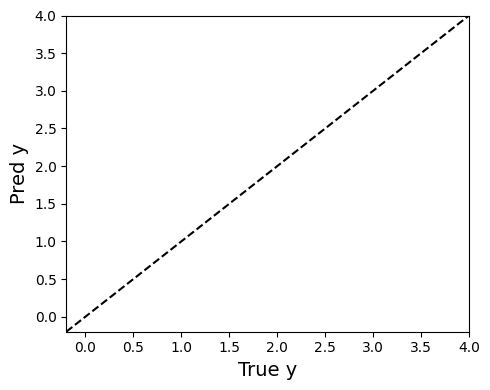

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.scatter(y, ml_model.predict(X))
ax1.plot([-0.2,4], [-0.2,4], '--k')

ax1.set_xlabel("True y", fontsize=14)
ax1.set_ylabel("Pred y", fontsize=14)

ax1.set_xlim([-0.2,4])
ax1.set_ylim([-0.2,4])

plt.tight_layout()

### 2.1 Compute Expected improvement for Candidate pool

In [ ]:
trade_off = 0.01
y_pred, y_std = ml_model.predict(X1, return_std=True)
y_train, y_train_std = ml_model.predict(X, return_std=True)

# Needed for noise-based model,
# otherwise use np.max(Y_train)
mu_train_opt = np.max(y_train)

with np.errstate(divide='warn'):
    imp = y_pred - mu_train_opt - trade_off
    Z = imp / y_std
    ei = imp * norm.cdf(Z) + y_std * norm.pdf(Z)
    ei[y_std == 0.0] = 0.0

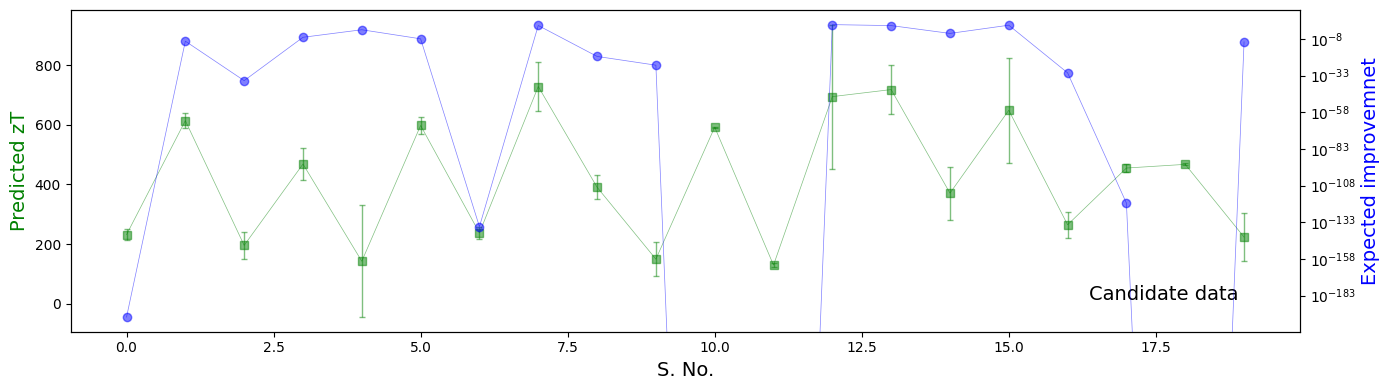

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14,4))

ax1.errorbar(np.arange(len(y_pred)), y_pred, y_std, fmt='-s', c='g', alpha=0.5, elinewidth=1, capsize=2, lw=0.5)
#ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('S. No.', fontsize=14)
ax1.set_ylabel('Predicted zT', fontsize=14, color='g')

ax1.text(0.95, 0.1, "Candidate data", transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)

#ax1.set_xlim([50,900])
#ax1.set_ylim([-0.2,0.5])

ax2 = ax1.twinx()

ax2.plot(ei, '-bo', lw=0.5, alpha=0.5)
ax2.set_yscale('log')
ax2.set_ylabel('Expected improvemnet', fontsize=14, color='b')

plt.tight_layout()
plt.show()



### Better visualization: Plot for first 50 candidates

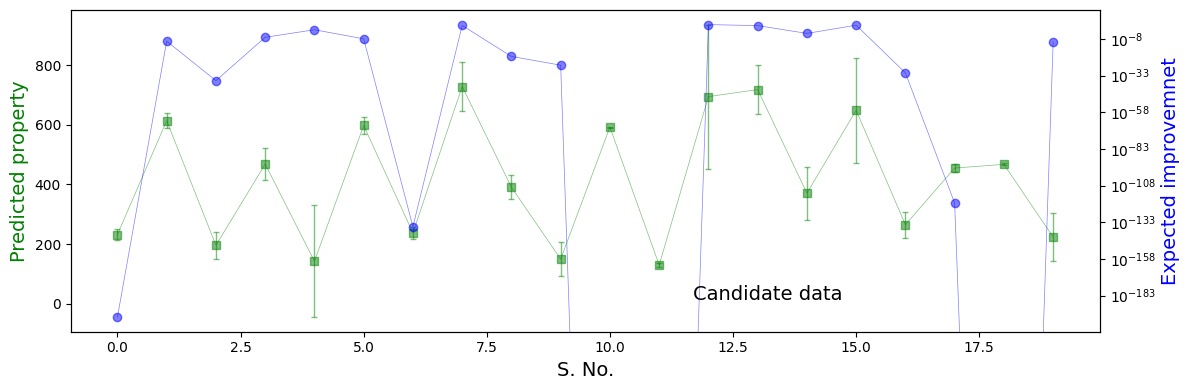

In [ ]:
nplots = 50
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,4))

ax1.errorbar(np.arange(len(y_pred))[:nplots], y_pred[:nplots], y_std[:nplots], fmt='-s', c='g', alpha=0.5, elinewidth=1, capsize=2, lw=0.5)
#ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('S. No.', fontsize=14)
ax1.set_ylabel('Predicted property', fontsize=14, color='g')

ax1.text(0.75, 0.1, "Candidate data", transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)

#ax1.set_xlim([50,900])
#ax1.set_ylim([-0.2,0.5])

ax2 = ax1.twinx()

ax2.plot(ei[:nplots], '-bo', lw=0.5, alpha=0.5)
ax2.set_yscale('log')
ax2.set_ylabel('Expected improvemnet', fontsize=14, color='b')

plt.tight_layout()
plt.show()



### Question
1. Do you notice any trend in the EI value? When is it small and when is it large?

### 2.2 Selecting candidate with maximum EI

In [ ]:
print("Best target property sample so far in the train data is %.4f" %best_train)

Best target property sample so far in the train data is 768.0000


In [ ]:
# sel_idx = np.argmax(ei)

# print("Selected candidate for next experiment ", new_data1.iloc[sel_idx]['HV'])

### 2.3 Next we do the experimnet and find the actual value

In [ ]:
# Assume the experimnet was performed the zT value was measured
# print("Exp. value for the selected candidate %.4f" %new_data1.iloc[sel_idx][target_col])

### 2.4 Next we update the training data and candidate pool

In [ ]:
# Add selected data to training data
# new_data = pd.concat([new_data, new_data1.iloc[sel_idx].to_frame().T], ignore_index=True)

# Delete selected data from candidate pool
# new_data1 = new_data1.drop(index=new_data1.iloc[sel_idx].name)

In [ ]:
print("New train data size:", len(new_data), "\nNew candidate data size: ", len(new_data1))

New train data size: 100 
New candidate data size:  20


### 3.1 Complete Active learning loop (with Expected Impeovemnet)
Next we perform all steps in active learning in a loop for 50 steps and accumulate the results

In [ ]:
results_ei = []

In [ ]:
hyperparams={'kernel': [cv_results.iloc[0]['kernel']],
            'alpha':[cv_results.iloc[0]['alpha']]}

In [ ]:
train_data = new_data
candidate_data = new_data1

In [ ]:
nloop = 10                                           #number of loops

In [ ]:
trade_off = 0.01
for exp_idx in range(nloop):

    # Step 1: Train ML model
    ml_model = train_gpr_model(X,y,hyperparams=hyperparams)

   # ml_model = recursive_feature_elimination(X,y,estimator = ,cv=5)

    # Step 2: Evaluate Acquisition function
    ei = expected_improvement(X1, X, ml_model, trade_off)

    # Step 3: Select best candidate
    sel_idx = np.argmax(ei)
    print("Selected candidate", candidate_data.iloc[sel_idx]['HV'])

    # Step 4: Perform experimnet and update training and candidate data pool
    results_ei.append(candidate_data.iloc[sel_idx][target_col])
    print("Exp. value for the selected candidate %.4f" %candidate_data.iloc[sel_idx][target_col])
    train_data = pd.concat([train_data, candidate_data.iloc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.iloc[sel_idx].name)
    print("Training data size: ", len(train_data), "\n Candidate pool size: ", len(candidate_data))

    X = train_data[Xcols]
    X1 = candidate_data[Xcols]
    y = train_data['HV']

/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



Best kernel with lowest CV error
sigma_c 299.1866 sigma_l 4.0163 alpha 0.3
Selected candidate 775.0
Exp. value for the selected candidate 775.0000
Training data size:  101 
 Candidate pool size:  19


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



Best kernel with lowest CV error
sigma_c 299.6884 sigma_l 4.0310 alpha 0.3
Selected candidate 639.0
Exp. value for the selected candidate 639.0000
Training data size:  102 
 Candidate pool size:  18


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



Best kernel with lowest CV error
sigma_c 301.2406 sigma_l 4.0209 alpha 0.3
Selected candidate 695.0
Exp. value for the selected candidate 695.0000
Training data size:  103 
 Candidate pool size:  17


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



Best kernel with lowest CV error
sigma_c 300.0689 sigma_l 4.0093 alpha 0.3
Selected candidate 720.0
Exp. value for the selected candidate 720.0000
Training data size:  104 
 Candidate pool size:  16


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sk


Best kernel with lowest CV error
sigma_c 298.6659 sigma_l 3.9787 alpha 0.3
Selected candidate 205.0
Exp. value for the selected candidate 205.0000
Training data size:  105 
 Candidate pool size:  15


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



Best kernel with lowest CV error
sigma_c 298.6661 sigma_l 3.9787 alpha 0.3
Selected candidate 423.0
Exp. value for the selected candidate 423.0000
Training data size:  106 
 Candidate pool size:  14


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



Best kernel with lowest CV error
sigma_c 299.7792 sigma_l 4.0017 alpha 0.3
Selected candidate 469.0
Exp. value for the selected candidate 469.0000
Training data size:  107 
 Candidate pool size:  13


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



Best kernel with lowest CV error
sigma_c 299.7190 sigma_l 4.0049 alpha 0.3
Selected candidate 295.0
Exp. value for the selected candidate 295.0000
Training data size:  108 
 Candidate pool size:  12


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



Best kernel with lowest CV error
sigma_c 297.7068 sigma_l 3.9809 alpha 0.3
Selected candidate 602.0
Exp. value for the selected candidate 602.0000
Training data size:  109 
 Candidate pool size:  11

Best kernel with lowest CV error
sigma_c 297.0798 sigma_l 3.9947 alpha 0.3
Selected candidate 665.0
Exp. value for the selected candidate 665.0000
Training data size:  110 
 Candidate pool size:  10


/usr/local/lib/python3.9/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


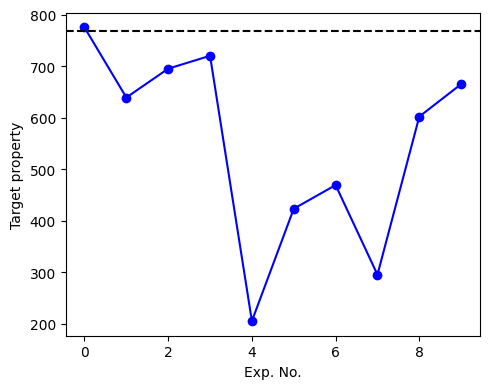

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(results_ei, '-bo', label='EI')
ax1.axhline(y=best_train, linestyle = '--', c='k')
ax1.set_xlabel('Exp. No.')
ax1.set_ylabel('Target property')

plt.tight_layout()

In [ ]:
max(results_ei)

775.0

In [ ]:
(results_ei > best_train).sum()

1

In [ ]:
np.argmax(results_ei)

0

### Question
2. Does EI and exploitation always perform better than exploration/random search?
3. What other improvemnets can be made in terms of ML model training?
4. Try different values of the nfrac parameter and see how many trials does the different acquisition functions take ON AVERAGE to suggest the highest bandgap system (=11.7 eV)? Remember for each value of nfrac you will have to run the above code multiple times to get good statistics. Convey your results using plots.

Issue with the Approach : Best canditate means highest prediction value. But here we are taking best canditate is the defination from our perspective. So predictive ability of Model is

In [ ]:
train_data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,...,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4,Unnamed: 0
0,7.0,139.0,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,-2.442590,1.931601,...,-0.735600,0.000000,-0.659447,-0.659447,0.000000,0.000000,0.686125,-0.821190,-0.835139,NaN
1,108.0,545.0,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.575486,-1.738410,...,-0.082933,0.218837,0.114522,0.114522,0.218837,0.218837,0.538307,0.209229,0.270661,NaN
2,146.0,701.0,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,1.093749,-2.322860,...,0.855442,0.414343,0.872863,0.872863,0.415263,0.405140,-0.972153,-0.098731,0.662067,NaN
3,37.0,207.0,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,-0.319490,0.221026,...,-0.326621,0.090351,-0.255700,-0.255700,0.090351,0.090675,0.706767,0.974089,-0.506048,NaN
4,141.0,655.0,0.149925,0.283358,0.283358,0.000000,0.283358,0.000000,0.241201,1.115530,...,-0.281224,0.149364,-0.099796,-0.099796,0.147663,0.148878,-0.802448,-0.977057,0.357031,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,68.0,423.0,0.181818,0.181818,0.181818,0.181818,0.181818,0.090909,0.371165,-0.394290,...,0.477953,0.180601,0.603534,0.603534,0.179956,0.179956,-0.052802,0.988809,0.283602,9.0
106,77.0,469.0,0.110000,0.000000,0.280000,0.270000,0.060000,0.280000,-0.170960,0.201583,...,0.373815,0.108557,0.457352,0.457352,0.109721,0.109585,0.694436,-0.497409,-0.374285,10.0
107,48.0,295.0,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.230839,0.005193,...,-0.179093,0.152715,-0.106321,-0.106321,0.152715,0.152715,0.121413,0.921223,0.183783,5.0
108,129.0,602.0,0.250000,0.166667,0.166667,0.083333,0.166667,0.166667,0.748791,-0.572730,...,0.637552,0.246411,0.753936,0.753936,0.246411,0.245197,-0.617386,0.930666,0.714435,14.0


In [ ]:
candidate_data

,Unnamed: 0,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,...,C.6,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4
3,3,40,238,0.090909,0.000000,0.181818,0.181818,0.181818,0.363636,-0.302790,...,0.000000,-0.340804,0.089113,-0.268653,-0.268653,0.090351,0.090675,0.854149,-0.264257,-0.481560
6,6,51,315,0.137931,0.000000,0.172414,0.172414,0.172414,0.344828,0.112354,...,0.000000,0.039975,0.135207,0.168082,0.168082,0.136904,0.137115,0.606555,-0.020218,-0.054525
4,4,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.283273,...,0.325881,-0.571430,0.165230,-0.475743,-0.475743,0.165230,0.165230,0.758715,0.056192,0.027533
7,7,55,358,0.166667,0.166667,0.166667,0.083333,0.166667,0.250000,0.329755,...,0.165728,-0.004197,0.164416,0.117406,0.117406,0.165230,0.165230,0.096234,0.981160,0.309563
1,1,18,158,0.000000,0.225000,0.100000,0.225000,0.225000,0.225000,-2.010640,...,0.221487,-0.978669,0.000000,-0.997619,-0.997619,0.000000,0.000000,0.931519,0.146396,-0.817474
13,13,120,576,0.305556,0.000000,0.138889,0.138889,0.138889,0.277778,0.905252,...,0.000000,0.834167,0.297527,0.912556,0.912556,0.299982,0.296858,-0.614733,-0.075414,0.718843
0,0,4,127,0.090909,0.227273,0.227273,0.000000,0.227273,0.227273,-0.289290,...,0.225321,-0.816709,0.090112,-0.860100,-0.860100,0.090112,0.090675,0.126254,0.090413,-0.392477
8,8,64,392,0.166667,0.000000,0.166667,0.166667,0.166667,0.333333,0.310678,...,0.000000,0.257112,0.163311,0.392600,0.392600,0.165230,0.165230,0.411991,0.059461,0.188474
12,12,98,521,0.193548,0.000000,0.161290,0.161290,0.161290,0.322581,0.467756,...,0.000000,0.432229,0.189528,0.563540,0.563540,0.191619,0.191305,0.210990,0.092405,0.379744
11,11,89,487,0.238095,0.190476,0.190476,0.000000,0.190476,0.190476,0.750231,...,0.189326,0.398036,0.234619,0.522913,0.522913,0.234619,0.233940,-0.772199,0.360974,0.777642


In [ ]:
test_X = candidate_data[Xcols]
test_X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,Dk_fG,Dk_fx,...,C.6,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4
3,0.090909,0.000000,0.181818,0.181818,0.181818,0.363636,-0.302790,0.245639,-0.350480,-0.227420,...,0.000000,-0.340804,0.089113,-0.268653,-0.268653,0.090351,0.090675,0.854149,-0.264257,-0.481560
6,0.137931,0.000000,0.172414,0.172414,0.172414,0.344828,0.112354,-0.094270,0.040244,0.211135,...,0.000000,0.039975,0.135207,0.168082,0.168082,0.136904,0.137115,0.606555,-0.020218,-0.054525
4,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.283273,-1.227010,-0.670300,-0.842130,...,0.325881,-0.571430,0.165230,-0.475743,-0.475743,0.165230,0.165230,0.758715,0.056192,0.027533
7,0.166667,0.166667,0.166667,0.083333,0.166667,0.250000,0.329755,-0.008690,-0.004240,0.267033,...,0.165728,-0.004197,0.164416,0.117406,0.117406,0.165230,0.165230,0.096234,0.981160,0.309563
1,0.000000,0.225000,0.100000,0.225000,0.225000,0.225000,-2.010640,0.269944,-1.482200,-2.787710,...,0.221487,-0.978669,0.000000,-0.997619,-0.997619,0.000000,0.000000,0.931519,0.146396,-0.817474
13,0.305556,0.000000,0.138889,0.138889,0.138889,0.277778,0.905252,-1.305980,1.269834,1.226548,...,0.000000,0.834167,0.297527,0.912556,0.912556,0.299982,0.296858,-0.614733,-0.075414,0.718843
0,0.090909,0.227273,0.227273,0.000000,0.227273,0.227273,-0.289290,1.180917,-0.977770,-0.328190,...,0.225321,-0.816709,0.090112,-0.860100,-0.860100,0.090112,0.090675,0.126254,0.090413,-0.392477
8,0.166667,0.000000,0.166667,0.166667,0.166667,0.333333,0.310678,-0.301990,0.267318,0.442340,...,0.000000,0.257112,0.163311,0.392600,0.392600,0.165230,0.165230,0.411991,0.059461,0.188474
12,0.193548,0.000000,0.161290,0.161290,0.161290,0.322581,0.467756,-0.496310,0.472892,0.635670,...,0.000000,0.432229,0.189528,0.563540,0.563540,0.191619,0.191305,0.210990,0.092405,0.379744
11,0.238095,0.190476,0.190476,0.000000,0.190476,0.190476,0.750231,-0.034480,0.429463,0.584122,...,0.189326,0.398036,0.234619,0.522913,0.522913,0.234619,0.233940,-0.772199,0.360974,0.777642


In [ ]:
y = candidate_data['HV']
y

3     238
6     315
4     249
7     358
1     158
13    576
0     127
8     392
12    521
11    487
Name: HV, dtype: int64

In [ ]:
y_pred, y_std = ml_model.predict(X1, return_std=True)

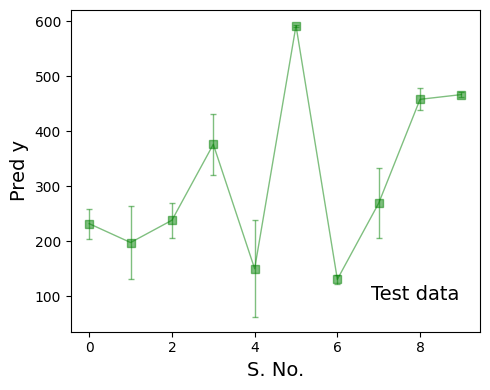

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))


ax1.errorbar(np.arange(len(y_pred)), y_pred, y_std*1.5, fmt='-s', c='g', alpha=0.5, elinewidth=1, capsize=2, lw=1)
#ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('S. No.', fontsize=14)
ax1.set_ylabel('Pred y', fontsize=14)

ax1.text(0.95, 0.1, "Test data", transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)

#ax1.set_xlim([50,900])
#ax1.set_ylim([50,900])

plt.tight_layout()
plt.show()

In [ ]:
# Visualisation
D1 = {'y_test': y, 'y_pred': y_pred, 'Error in Prediction': [a - b for a, b in zip(y, y_pred)]}

# Create the DataFrame
result = pd.DataFrame(D1)

# Display the DataFrame
print(result)

    y_test      y_pred  Error in Prediction
3      238  231.766710             6.233290
6      315  197.504981           117.495019
4      249  238.065036            10.934964
7      358  375.964511           -17.964511
1      158  149.916461             8.083539
13     576  591.444812           -15.444812
0      127  130.611582            -3.611582
8      392  269.033464           122.966536
12     521  457.715554            63.284446
11     487  466.323222            20.676778


In [ ]:
# First we will define function to make plots. This will make the code simpler.

def polt_parity(y_cv_test,y_pred_test, y_cv_train=None,y_pred_train=None, label=None, ylim=[50,900]):
    """
    Function to make parity plots.
    """

    # Plot Parity plot
    rmse_test = np.sqrt(mean_squared_error(y_cv_test,y_pred_test))
    r2_test = r2_score(y_cv_test,y_pred_test)

    if y_cv_train is None:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharey=True, sharex=True)
    else:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=True)

    ax1.scatter(y_cv_test,y_pred_test)
    ax1.text(0.95, 0.26, label, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.1, "R$^2$: %.2f"%r2_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.plot(ylim, ylim, '--k')
    ax1.set_xlabel('True y', fontsize=14)
    ax1.set_ylabel('Pred y', fontsize=14)
    ax1.set_xlim(ylim[0],ylim[1])
    ax1.set_ylim(ylim[0],ylim[1])

    if y_cv_train is not None:
        rmse_train = np.sqrt(mean_squared_error(y_cv_train,y_pred_train))
        r2_train = r2_score(y_cv_train,y_pred_train)

        ax2.scatter(y_cv_train,y_pred_train, c='m')
        ax2.text(0.95, 0.26, "Train", transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.plot(ylim, ylim, '--k')

        ax2.set_xlabel('True y', fontsize=14)
        ax2.set_xlim(ylim[0],ylim[1])
        ax2.set_ylim(ylim[0],ylim[1])

    plt.tight_layout()
    plt.show()

    return None

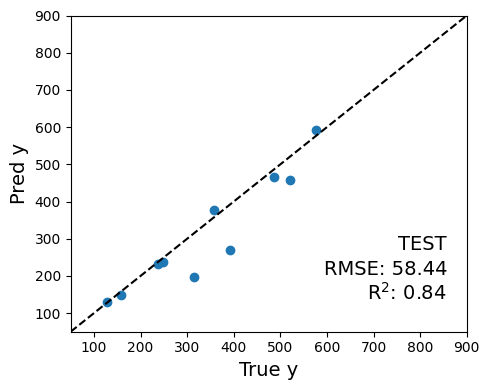

Root mean squared error: 58.44


In [ ]:
rmse_test = np.sqrt(mean_squared_error(y, y_pred))
r2_test = r2_score(y, y_pred)

# Plot Parity plot
polt_parity(y,y_pred,label="TEST")

#print("Kernel parameters: %s"%(ml_model.kernel_))
print("Root mean squared error: %.2f" % rmse_test)
#print("Coefficient of determination: %.2f" % r2_test)